In [3]:
from datetime import datetime, timedelta

import cmcrameri as cmc  # noqa: F401
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
import pystac_client
import rioxarray  # noqa: F401
import xarray as xr
from odc.geo.geobox import GeoBox
from shapely.geometry import Polygon
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [4]:
dx = 0.0006  # 60m resolution
epsg = 4326

# Set Spatial extent
latmin, latmax = 47.86, 48.407
lonmin, lonmax = 16.32, 16.9
bounds = (lonmin, latmin, lonmax, latmax)


# Set Temporal extent
start_date = datetime(year=2024, month=5, day=1)
end_date = start_date + timedelta(days=10)

time_format = "%Y-%m-%d"
date_query = start_date.strftime(time_format) + "/" + end_date.strftime(time_format)

# Search for Sentinel-2 data
items = (
    pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    .search(
        bbox=bounds,
        collections=["sentinel-2-l2a"],
        datetime=date_query,
        limit=100,
    )
    .item_collection()
)
print(len(items), "scenes found")

10 scenes found


In [5]:
# define a geobox for my region
geobox = GeoBox.from_bbox(bounds, crs=f"epsg:{epsg}", resolution=dx)

# lazily combine items into a datacube
dc = odc.stac.load(
    items,
    bands=["scl", "red", "green", "blue", "nir"],
    chunks={"time": 5, "x": 600, "y": 600},
    geobox=geobox,
    resampling="bilinear",
)
dc

<xarray.Dataset> Size: 79MB
Dimensions:      (latitude: 913, longitude: 967, time: 10)
Coordinates:
  * latitude     (latitude) float64 7kB 48.41 48.41 48.41 ... 47.86 47.86 47.86
  * longitude    (longitude) float64 8kB 16.32 16.32 16.32 ... 16.9 16.9 16.9
  * time         (time) datetime64[ns] 80B 2024-05-01T09:57:21.858000 ... 202...
    spatial_ref  int32 4B 4326
Data variables:
    scl          (time, latitude, longitude) uint8 9MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 18MB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


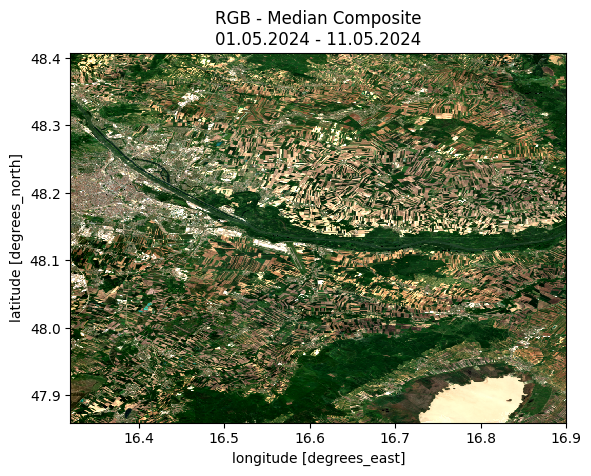

In [6]:
# define a mask for valid pixels (non-cloud)


def is_valid_pixel(data):
    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data == 11)


dc["valid"] = is_valid_pixel(dc.scl)

# compute the masked median
rgb_median = (
    dc[["red", "green", "blue"]]
    .where(dc.valid)
    .to_dataarray(dim="band")
    .median(dim="time")
    .astype(int)
)

# plot the median composite
title_rgb = (
    "RGB - Median Composite"
    + f"\n{start_date.strftime('%d.%m.%Y')} - {end_date.strftime('%d.%m.%Y')}"
)
rgb_median.plot.imshow(robust=True).axes.set_title(title_rgb)
plt.show()

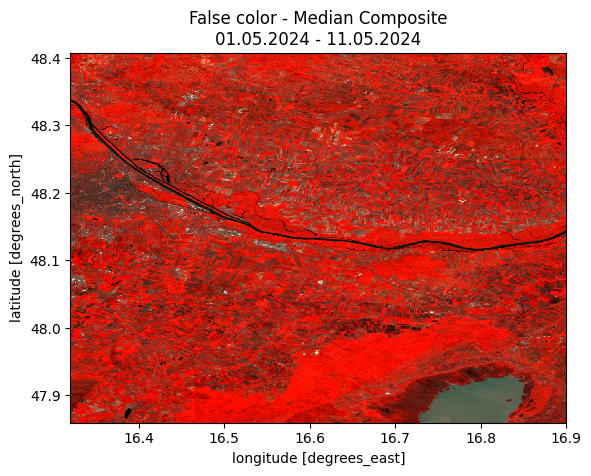

In [7]:
# compute a false color image
# near infrared instead of red
fc_median = (
    dc[["nir", "green", "blue"]]
    .where(dc.valid)
    .to_dataarray(dim="band")
    .transpose(..., "band")
    .median(dim="time")
    .astype(int)
)

title_fc = (
    "False color - Median Composite"
    + f"\n{start_date.strftime('%d.%m.%Y')} - {end_date.strftime('%d.%m.%Y')}"
)
fc_median.plot.imshow(robust=True).axes.set_title(title_fc)
plt.show()

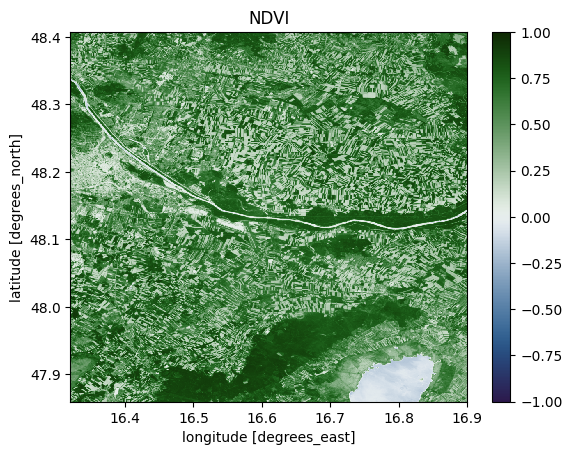

In [8]:
# Normalized Difference Vegetation Index (NDVI)


def normalized_difference(a, b):
    return (a - b * 1.0) / (a + b)


ndvi = normalized_difference(dc.nir, dc.red)
ndvi.median(dim="time").plot.imshow(cmap="cmc.cork", vmin=-1, vmax=1).axes.set_title(
    "NDVI"
)
plt.show()

In [9]:
# Define Polygons
forest_areas = {
    0: [
        Polygon(
            [
                (16.482772, 47.901753),
                (16.465133, 47.870124),
                (16.510142, 47.874382),
                (16.482772, 47.901753),
            ]
        )
    ],
    1: [
        Polygon(
            [
                (16.594079, 47.938855),
                (16.581914, 47.894454),
                (16.620233, 47.910268),
                (16.594079, 47.938855),
            ]
        )
    ],
    2: [
        Polygon(
            [
                (16.67984, 47.978998),
                (16.637263, 47.971091),
                (16.660376, 47.929123),
                (16.67984, 47.978998),
            ]
        )
    ],
    3: [
        Polygon(
            [
                (16.756477, 48.000286),
                (16.723024, 47.983256),
                (16.739446, 47.972916),
                (16.756477, 48.000286),
            ]
        )
    ],
    4: [
        Polygon(
            [
                (16.80696, 48.135923),
                (16.780806, 48.125583),
                (16.798445, 48.115243),
                (16.80696, 48.135923),
            ]
        )
    ],
    5: [
        Polygon(
            [
                (16.684097, 48.144438),
                (16.664634, 48.124366),
                (16.690788, 48.118892),
                (16.684097, 48.144438),
            ]
        )
    ],
    6: [
        Polygon(
            [
                (16.550894, 48.169984),
                (16.530822, 48.165118),
                (16.558801, 48.137139),
                (16.550894, 48.169984),
            ]
        )
    ],
    7: [
        Polygon(
            [
                (16.588604, 48.402329),
                (16.556976, 48.401112),
                (16.580697, 48.382865),
                (16.588604, 48.402329),
            ]
        )
    ],
}

nonforest_areas = {
    0: [
        Polygon(
            [
                (16.674974, 48.269126),
                (16.623882, 48.236281),
                (16.682272, 48.213168),
                (16.674974, 48.269126),
            ]
        )
    ],
    1: [
        Polygon(
            [
                (16.375723, 48.228374),
                (16.357476, 48.188839),
                (16.399444, 48.185798),
                (16.375723, 48.228374),
            ]
        )
    ],
    2: [
        Polygon(
            [
                (16.457834, 48.26426),
                (16.418907, 48.267301),
                (16.440804, 48.23324),
                (16.457834, 48.26426),
            ]
        )
    ],
    3: [
        Polygon(
            [
                (16.519266, 48.101861),
                (16.470607, 48.100645),
                (16.500411, 48.07145),
                (16.519266, 48.101861),
            ]
        )
    ],
    4: [
        Polygon(
            [
                (16.453577, 48.051986),
                (16.412217, 48.067192),
                (16.425598, 48.012451),
                (16.453577, 48.051986),
            ]
        )
    ],
}

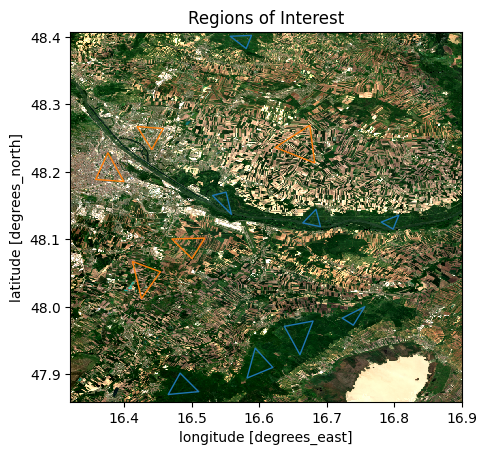

In [10]:
# Geoppandas Dataframe from Polygons
forest_df = gpd.GeoDataFrame(
    {"geometry": [poly[0] for poly in forest_areas.values()]}, crs="EPSG:4326"
)
nonforest_df = gpd.GeoDataFrame(
    {"geometry": [poly[0] for poly in nonforest_areas.values()]},
    crs="EPSG:4326",
)


# Plotting Regions of Interest
fig, ax = plt.subplots()
rgb_median.plot.imshow(ax=ax, robust=True)
forest_df.plot(ax=ax, ec="C0", fc="none")
nonforest_df.plot(ax=ax, ec="C1", fc="none")
ax.set_title("Regions of Interest")
ax.set_aspect("equal")
plt.show()

In [11]:
# Classifiying dataset (only necessary bands)
bands = ["red", "green", "blue", "nir"]
ds_class = dc[bands].where(dc.valid).median(dim="time")
ds_class = ds_class.fillna(0)


def clip_array(ds: xr.Dataset, polygons):
    clipped = ds.rio.clip(polygons, invert=False, all_touched=False, drop=True)
    clipped_nan = clipped.where(clipped == ds)
    return clipped_nan


# Dictionaries with Dataarrays, each clipped by a Polygon
data_dict_feat = {
    idx: clip_array(ds_class, polygon) for idx, polygon in forest_areas.items()
}
data_dict_nonfeat = {
    idx: clip_array(ds_class, polygon) for idx, polygon in nonforest_areas.items()
}

In [12]:
# Reshape the polygon dataarrays to get a tuple (one value per band) of pixel values
feat_data = [
    xarray.to_array().values.reshape(len(bands), -1).T
    for xarray in data_dict_feat.values()
]  # replaced median_data_dict_feat with data_dict_feat
nonfeat_data = [
    xarray.to_array().values.reshape(len(bands), -1).T
    for xarray in data_dict_nonfeat.values()
]  # replaced median_data_dict_feat with data_dict_feat

# The rows of the different polygons are concatenated to a single array for further processing
feat_values = np.concatenate(feat_data)
nonfeat_values = np.concatenate(nonfeat_data)

# Drop Nan Values
X_feat_data = feat_values[~np.isnan(feat_values).any(axis=1)]
X_nonfeat_data = nonfeat_values[~np.isnan(nonfeat_values).any(axis=1)]

In [13]:
# Creating Output Vector (1 for pixel is features; 0 for pixel is not feature)
y_feat_data = np.ones(X_feat_data.shape[0])
y_nonfeat_data = np.zeros(X_nonfeat_data.shape[0])

# Concatenate all Classes for training
X = np.concatenate([X_feat_data, X_nonfeat_data])
y = np.concatenate([y_feat_data, y_nonfeat_data])

# Split into Training and Testing Data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

In [14]:
image_data = (
    ds_class[bands].to_array(dim="band").transpose("latitude", "longitude", "band")
)

# Reshape the image data
num_of_pixels = ds_class.sizes["longitude"] * ds_class.sizes["latitude"]
num_of_bands = len(bands)
X_image_data = image_data.values.reshape(num_of_pixels, num_of_bands)

In [15]:
# Naive Bayes initialization and training
nb = GaussianNB()
nb_test = nb.fit(X_train, y_train)
nb_predict = nb.predict(X_test)

# Prediction on image
nb_predict_img = nb.predict(X_image_data)
nb_predict_img = nb_predict_img.reshape(
    ds_class.sizes["latitude"], ds_class.sizes["longitude"]
)

# Adding the Naive Bayes Prediction to the dataset
ds_class["NB-forest"] = xr.DataArray(
    nb_predict_img,
    dims=["latitude", "longitude"],
    coords={
        "longitude": ds_class["longitude"],
        "latitude": ds_class["latitude"],
    },
)

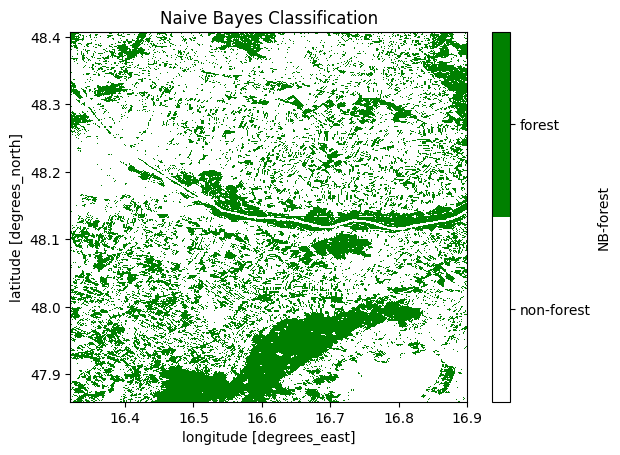

NAIVE BAYES: 
               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      6626
         1.0       0.81      0.95      0.87      5485

    accuracy                           0.88     12111
   macro avg       0.88      0.88      0.88     12111
weighted avg       0.89      0.88      0.88     12111



,Predicted Negative,Predicted Positive
Actual Negative,5415,1211
Actual Positive,290,5195


In [16]:
# Plot Naive Bayes
alpha = 1
cmap_green = colors.ListedColormap([(1, 1, 1, alpha), "green"])

plot = ds_class["NB-forest"].plot.imshow(
    cmap=cmap_green, cbar_kwargs={"ticks": [0.25, 0.75]}
)
cbar = plot.colorbar
cbar.set_ticklabels(["non-forest", "forest"])
plot.axes.set_title("Naive Bayes Classification")
plt.show()

# Print the Classification report
print("NAIVE BAYES: \n " + classification_report(y_test, nb_predict))

# Print the confusion matrix
con_mat_nb = pd.DataFrame(
    confusion_matrix(y_test, nb_predict),
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)
display(con_mat_nb)

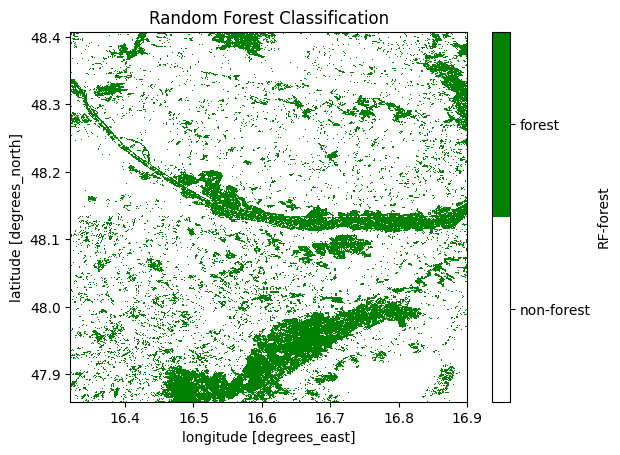

RANDOM FOREST: 
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      6626
         1.0       0.94      0.95      0.95      5485

    accuracy                           0.95     12111
   macro avg       0.95      0.95      0.95     12111
weighted avg       0.95      0.95      0.95     12111



,Predicted Negative,Predicted Positive
Actual Negative,6294,332
Actual Positive,273,5212


In [17]:
# Random Forest initialization and training
rf = RandomForestClassifier(n_estimators=100)
rf_test = rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

# Prediction on image
rf_predict_img = rf.predict(X_image_data)
rf_predict_img = rf_predict_img.reshape(
    ds_class.sizes["latitude"], ds_class.sizes["longitude"]
)

# Adding the Random Forest Prediction to the dataset
ds_class["RF-forest"] = xr.DataArray(
    rf_predict_img,
    dims=["latitude", "longitude"],
    coords={
        "longitude": ds_class["longitude"],
        "latitude": ds_class["latitude"],
    },
)

plot = ds_class["RF-forest"].plot.imshow(
    cmap=cmap_green, cbar_kwargs={"ticks": [0.25, 0.75]}
)
cbar = plot.colorbar
cbar.set_ticklabels(["non-forest", "forest"])
plot.axes.set_title("Random Forest Classification")
plt.show()

# Print the Classification report
print("RANDOM FOREST: \n " + classification_report(y_test, rf_predict))

# Print the confusion matrix
con_mat_rf = pd.DataFrame(
    confusion_matrix(y_test, rf_predict),
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)
display(con_mat_rf)

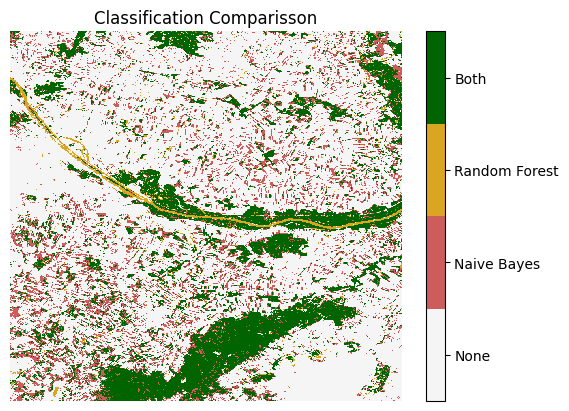

In [18]:
cmap_trio = colors.ListedColormap(["whitesmoke", "indianred", "goldenrod", "darkgreen"])


double_clf = ds_class["NB-forest"] + 2 * ds_class["RF-forest"]

fig, ax = plt.subplots()
cax = ax.imshow(double_clf, cmap=cmap_trio, interpolation="none")

# Add a colorbar with custom tick labels
cbar = fig.colorbar(cax, ticks=[1 * 0.375, 3 * 0.375, 5 * 0.375, 7 * 0.375])
cbar.ax.set_yticklabels(["None", "Naive Bayes", "Random Forest", "Both"])
ax.set_title("Classification Comparisson")
ax.set_axis_off()
plt.show()

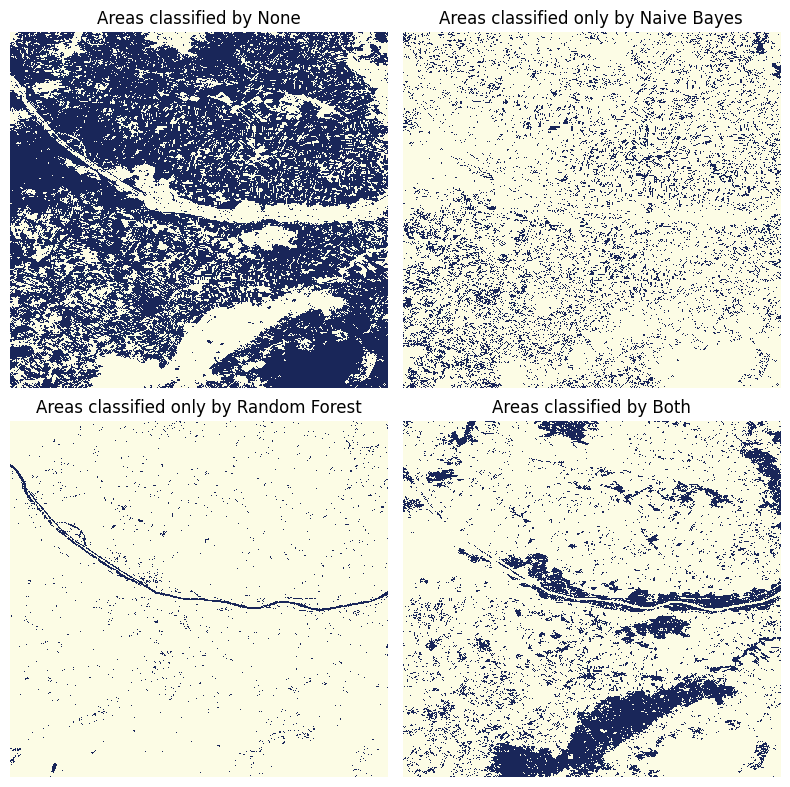

In [19]:
# Plot only one class, either None (0), Naive Bayes (1), Random Forest (2), or Both (3)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax = axs.ravel()

for i in range(4):
    ax[i].imshow(double_clf == i, cmap="cmc.oleron_r", interpolation="none")
    category = [
        "by None",
        "only by Naive Bayes",
        "only by Random Forest",
        "by Both",
    ][i]
    title = "Areas classified " + category
    ax[i].set_title(title)
    ax[i].set_axis_off()

plt.tight_layout()

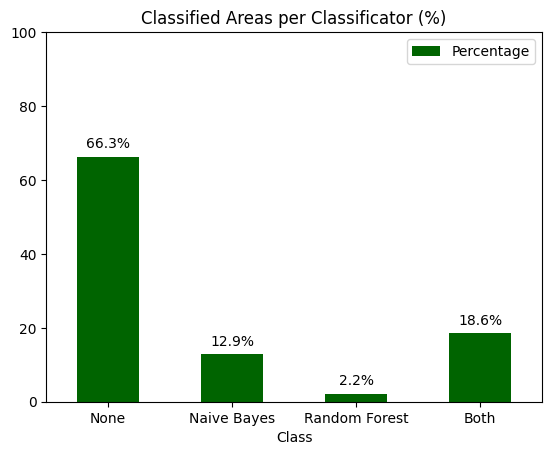

In [20]:
counts = {}
for num in range(0, 4):
    num_2_class = {0: "None", 1: "Naive Bayes", 2: "Random Forest", 3: "Both"}
    counts[num_2_class[num]] = int((double_clf == num).sum().values)

class_counts_df = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])
class_counts_df["Percentage"] = (
    class_counts_df["Count"] / class_counts_df["Count"].sum()
) * 100
ax = class_counts_df.plot.bar(
    x="Class",
    y="Percentage",
    rot=0,
    color="darkgreen",
    ylim=(0, 100),
    title="Classified Areas per Classificator (%)",
)

# Annotate the bars with the percentage values
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )